In [4]:
import sys
import asyncio
import aiohttp
sys.path.append('/Users/andreas/fun/useful_py_func/pyTibber/tibber/')
#sys.path.append('/home/andram/fun/LED-env/lib/python3.11/site-packages/tibber')
from tibber import Tibber, gql_queries
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser

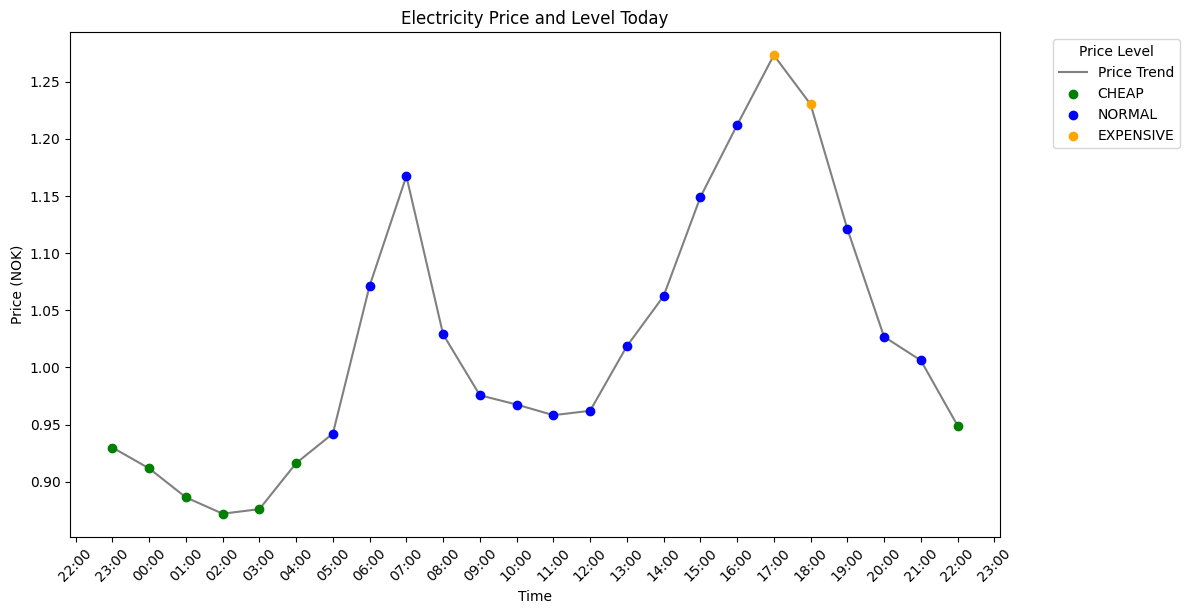

In [3]:
async def main():
    TOKEN = "U4L8yS_OHsfgKndAhNQZ8K-JYElbNUagYvToCF3ZPVE"
    USER_AGENT = "LED_client"
    HOME_ID = "975996b6-e7ca-4fbf-9f72-61e2df95bc0c"

    tibber_connection = Tibber(TOKEN, user_agent=USER_AGENT)
    await tibber_connection.update_info()
    
    # Fetch price information for today
    query = gql_queries.PRICE_INFO % HOME_ID
    data = await tibber_connection.execute(query)
    
    # Extract price information
    today_prices = data['viewer']['home']['currentSubscription']['priceInfo']['today']
    
    # Preparing data for plotting
    times = [parser.parse(price['startsAt']) for price in today_prices]
    prices = [price['total'] for price in today_prices]
    levels = [price['level'] for price in today_prices]

    await tibber_connection.close_connection()

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Mapping of levels to colors for plotting
    level_colors = {
        'NORMAL': 'blue',
        'CHEAP': 'green',
        'VERY_CHEAP': 'lightgreen',
        'EXPENSIVE': 'orange',
        'VERY_EXPENSIVE': 'red'
    }

    # Plot lines connecting the scatter points
    ax.plot(times, prices, color='grey', label='Price Trend', linestyle='-', marker='', zorder=1)

    # Plot each price point with a color indicating its level
    for time, price, level in zip(times, prices, levels):
        ax.scatter(time, price, color=level_colors[level], label=level if level not in ax.get_legend_handles_labels()[1] else "", zorder=2)

    ax.set_xlabel('Time')
    ax.set_ylabel('Price (NOK)')

    # Custom legend handling to ensure each level is represented once
    handles, labels = ax.get_legend_handles_labels()
    # Create a legend mapping each price level to its color, plus the price trend line
    legend_labels = {label: handle for handle, label in zip(handles, labels)}
    ax.legend(legend_labels.values(), legend_labels.keys(), title='Price Level', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format the x-axis to show dates and times more clearly
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.title('Electricity Price and Level Today')
    plt.tight_layout()  # Adjust layout
    plt.xticks(rotation=45)
    plt.show()

await main()

In [5]:
class PriceCache:
    def __init__(self):
        self.cache = {'today': {}, 'tomorrow': {}}

    def update_cache(self, price_info):
        # Update today's prices
        for entry in price_info['viewer']['home']['currentSubscription']['priceInfo']['today']:
            starts_at = parser.isoparse(entry['startsAt'])
            hour = starts_at.strftime('%H')  # Formatting to get the hour part as a string
            self.cache['today'][hour] = {
                'total': entry['total'],
                'startsAt': starts_at,
                'level': entry['level']
            }

        # Update tomorrow's prices
        for entry in price_info['viewer']['home']['currentSubscription']['priceInfo']['tomorrow']:
            starts_at = parser.isoparse(entry['startsAt'])
            hour = starts_at.strftime('%H')  # Formatting to get the hour part as a string
            self.cache['tomorrow'][hour] = {
                'total': entry['total'],
                'startsAt': starts_at,
                'level': entry['level']
            }

    def get_price_info(self, day, hour):
        # Access price info by day and hour, e.g., get_price_info('today', '13')
        if hour in self.cache[day]:
            entry = self.cache[day][hour]
            return {
                'total': entry['total'],
                'startsAt': entry['startsAt'].isoformat(),
                'level': entry['level']
            }
        return None

async def fetch_prices(tibber_connection, cache, home_id, retry_count=0, max_retries=5):
    try:
        query = gql_queries.PRICE_INFO % home_id
        data = await tibber_connection.execute(query)
        if data:
            cache.update_cache(data)
            print("Cache updated.")
            return True  # Successful fetch
        else:
            print("No data returned.")
            raise ValueError("No data returned from API.")
    except Exception as e:
        print(f"Fetch failed: {e}")
        if retry_count < max_retries:
            wait_time = min(2 ** retry_count, 30) * 60  # Exponential back-off with a max of 30 minutes
            print(f"Retrying in {wait_time // 60} minutes...")
            await asyncio.sleep(wait_time)
            return await fetch_prices(tibber_connection, cache, home_id, retry_count + 1, max_retries)
        else:
            print("Maximum retries reached. Giving up for today.")
            return False  # Failed after retries


async def daily_updates(tibber_connection, cache, home_id):
    while True:
        await fetch_prices(tibber_connection, cache, home_id)
        
        norway_timezone = timezone(timedelta(hours=1))
        now = datetime.now(norway_timezone)
        next_update = (now + timedelta(days=1)).replace(hour=18, minute=0, second=0, microsecond=0)
        delay_seconds = 10#(next_update - now).total_seconds()
        print(cache.get_price_info('today','16'))
        print(f"Next update in {delay_seconds // 3600} hours, {(delay_seconds % 3600) // 60} minutes.")
        await asyncio.sleep(delay_seconds)

async def main():
    TOKEN = "U4L8yS_OHsfgKndAhNQZ8K-JYElbNUagYvToCF3ZPVE"
    USER_AGENT = "LED_client"
    HOME_ID = "975996b6-e7ca-4fbf-9f72-61e2df95bc0c"

    tibber_connection = Tibber(TOKEN, user_agent=USER_AGENT)
    await tibber_connection.update_info()
    
    cache = PriceCache()
    await daily_updates(tibber_connection, cache, HOME_ID)

    await tibber_connection.close_connection()

await main()

Cache updated.
{'total': 1.1489, 'startsAt': '2024-02-14T16:00:00+01:00', 'level': 'NORMAL'}
Next update in 0 hours, 0 minutes.
Cache updated.
{'total': 1.1489, 'startsAt': '2024-02-14T16:00:00+01:00', 'level': 'NORMAL'}
Next update in 0 hours, 0 minutes.


CancelledError: 